In [1]:
%matplotlib inline



import glob
import h5py
import numpy as np
from brainspace.gradient import GradientMaps
from brainspace.gradient import alignment
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import helpers

# Loading surface mask and distance matrices (for each surface)


HCPFilenamesList = glob.glob('../IndSubHCP/*.mat')
HCPFilenamesList.sort()
SurfaceMask=np.loadtxt('surfBilateralMask.txt')

numFiles=len(HCPFilenamesList)
numV_l=np.count_nonzero(SurfaceMask[:5000])
numV_l=np.count_nonzero(SurfaceMask[5000:])

num_bins=20
dist_mat_file = "SurfL10kConte.txt"
dist_mat_file_r = "SurfR10kConte.txt"
dist_file=np.loadtxt(dist_mat_file)
dist_file_r=np.loadtxt(dist_mat_file_r)
dist_file_masked=dist_file[np.ix_(SurfaceMask[:5000]==1,SurfaceMask[:5000]==1)]
dist_file_masked_r=dist_file_r[np.ix_(SurfaceMask[5000:]==1,SurfaceMask[5000:]==1)]


FC_l=np.zeros([dist_file_masked.shape[0],dist_file_masked.shape[0]])
FC_r=np.zeros([dist_file_masked_r.shape[0],dist_file_masked_r.shape[0]])


#Loading surface 2D FMRI and calculating group average functional connectivity

for i,dataName in enumerate(HCPFilenamesList):


    print(dataName)
    f = h5py.File(dataName)
    arrays = {}
    for k, v in f.items():
        arrays[k] = np.array(v)

    IndData1=arrays['rfMRI_REST1_LR']
    
    tempData=IndData1[:5000,:]
    tempDataReduced=tempData[SurfaceMask[:5000]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    tempFC=np.arctanh(tempFC)
    np.fill_diagonal(tempFC,3)
    FC_l=FC_l+tempFC
    
    tempData=IndData1[5000:,:]
    tempDataReduced=tempData[SurfaceMask[5000:]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    tempFC=np.arctanh(tempFC)
    np.fill_diagonal(tempFC,3)
    FC_r=FC_r+tempFC
    

FC_l=FC_l/(numFiles)
FC_l=np.tanh(FC_l)

FC_r=FC_r/(numFiles)
FC_r=np.tanh(FC_r)

../IndSubHCP/HCP_100408_downsample_hemiTimeseries.mat


/var/folders/sf/n3ybtcn11h30c98lywmccxr80000gn/T/ipykernel_43475/3773704282.py:47: RuntimeWarning: divide by zero encountered in arctanh
  tempFC=np.arctanh(tempFC)
/var/folders/sf/n3ybtcn11h30c98lywmccxr80000gn/T/ipykernel_43475/3773704282.py:54: RuntimeWarning: divide by zero encountered in arctanh
  tempFC=np.arctanh(tempFC)


../IndSubHCP/HCP_100610_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_101006_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_102513_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_102816_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_103414_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_103515_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_103818_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_104416_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_105620_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_106521_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_107018_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_108222_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_108525_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_109123_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_109830_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_110007_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_110411_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_110613_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_111009_down

In [2]:
#fit theoretical variograms to group FC data (adapted to explore different maximum lengths)
from scipy import special
from scipy.optimize import curve_fit
import math

num_bins=20
#hVw_l,evVw_l=helpers.emp_variogram_vwise_conn(FC_l,dist_file_masked,num_bins,[0,150]) #vary last number for maximum range 
#hVw_r,evVw_r=helpers.emp_variogram_vwise_conn(FC_r,dist_file_masked_r,num_bins,[0,150]) #vary last number for maximum range 

#hVw_l,evVw_l=helpers.emp_variogram_vwise_conn(FC_l,dist_file_masked,num_bins,[0,175]) #vary last number for maximum range 
#hVw_r,evVw_r=helpers.emp_variogram_vwise_conn(FC_r,dist_file_masked_r,num_bins,[0,175]) #vary last number for maximum range 

hVw_l,evVw_l=helpers.emp_variogram_vwise_conn(FC_l,dist_file_masked,num_bins,[0,200]) #vary last number for maximum range 
hVw_r,evVw_r=helpers.emp_variogram_vwise_conn(FC_r,dist_file_masked_r,num_bins,[0,200]) #vary last number for maximum range 

#Different functions for different theoretical variogram models


def hole(h, r, c0,nugget):
    a = r/3
    theoVar=nugget + c0*(1-np.sin(h/a)/(h/a))

    return theoVar
              
def gaussian(h, r, c0, nugget):
    a = r / 2
    return nugget + c0 * (1. - np.exp(- (h ** 2 / a ** 2)))

def exponential(h,r,c0,nugget):
    theoVar=nugget+c0*(1-np.exp(-h/(r/3)))
    return theoVar

def powerModel(h,scale,exponent,nugget):
    return  scale* h**exponent + nugget

models=[hole, exponential, gaussian, powerModel]



#Left surface

clipStart=1
clipEnd=18
#clipEnd=28

ModelPred_evVw_l=np.zeros([evVw_l.shape[0],4,num_bins-3])
ModelSSE_evVw_l=np.zeros([evVw_l.shape[0],4])
ModelCof_evVw_l=np.zeros([evVw_l.shape[0],4,3])

# Calculate variogram model parameters per vertex

for j in range(evVw_l.shape[0]):
    y=evVw_l[j,clipStart:clipEnd]
    x=hVw_l[j,clipStart:clipEnd]
    bounds = (0.00001, [np.nanmax(x),np.nanmax(y),np.nanmax(y)/10])

    cof = None
    cov = None

    for ind,model in enumerate(models):

        cof, cov = curve_fit(model,x, y, method='trf',p0=bounds[1],bounds=bounds,maxfev=5000)
        v_pred=model(x,*cof)
        ModelPred_evVw_l[j,ind,:]=v_pred
        ModelSSE_evVw_l[j,ind]=np.sum((v_pred-y)**2)
        ModelCof_evVw_l[j,ind,:]=cof


#Right surface
        
ModelPred_evVw_r=np.zeros([evVw_r.shape[0],4,num_bins-3])
ModelSSE_evVw_r=np.zeros([evVw_r.shape[0],4])
ModelCof_evVw_r=np.zeros([evVw_r.shape[0],4,3])


for j in range(evVw_r.shape[0]):
    y=evVw_r[j,clipStart:clipEnd]

    x=hVw_r[j,clipStart:clipEnd]

    bounds = (0.00001, [np.nanmax(x),np.nanmax(y),np.nanmax(y)/10])

    cof = None
    cov = None

    for ind,model in enumerate(models):

        cof, cov = curve_fit(model,x, y, method='trf',p0=bounds[1],bounds=bounds,maxfev=5000)
        v_pred=model(x,*cof)
        ModelPred_evVw_r[j,ind,:]=v_pred
        ModelSSE_evVw_r[j,ind]=np.sum((v_pred-y)**2)
        ModelCof_evVw_r[j,ind,:]=cof



    


In [3]:
#Save out range and sill from model

tempData=np.zeros([5000,3])
tempData[SurfaceMask[:5000]==1,:]=ModelCof_evVw_l[:,:,0]
np.savetxt('./imagesAvG/FC_Range_left.txt',tempData)
tempData=np.zeros([5000,3])
tempData[SurfaceMask[5000:]==1,:]=ModelCof_evVw_r[:,:,0]
np.savetxt('./imagesAvG/FC_Range_right.txt',tempData)


tempData=np.zeros([5000,3])
tempData[SurfaceMask[:5000]==1,:]=ModelCof_evVw_l[:,:,1]
np.savetxt('./imagesAvG/FC_Sill_left.txt',tempData)
tempData=np.zeros([5000,3])
tempData[SurfaceMask[5000:]==1,:]=ModelCof_evVw_r[:,:,1]
np.savetxt('./imagesAvG/FC_Sill_right.txt',tempData)


ValueError: shape mismatch: value array of shape (4554,4) could not be broadcast to indexing result of shape (4554,3)

In [4]:
# Calculate functional gradients
from brainspace.gradient import GradientMaps
from brainspace.gradient import alignment



numComp=3

#gmr = GradientMaps(n_components=numComp, approach='dm', kernel='normalized_angle')
gmr = GradientMaps(n_components=numComp,approach='le')

gmr.fit(FC_r)

tempData=np.zeros([5000,3])
tempData[SurfaceMask[5000:]==1,:]=gmr.gradients_
#np.savetxt('./imagesAvG/GradientFC_right.txt',tempData)


gml = GradientMaps(n_components=numComp,approach='le')
gml.fit(FC_l)
tempData=np.zeros([5000,3])
tempData[SurfaceMask[:5000]==1,:]=gml.gradients_




/opt/homebrew/lib/python3.9/site-packages/brainspace/gradient/embedding.py:206: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


In [ ]:
# Plot range/sill colored by principal functional gradient 

import matplotlib

matplotlib.rc_file_defaults()


fig, axs = plt.subplots(1,2,figsize=(8,4))
fig.patch.set_alpha(0)


axs[0].scatter(ModelCof_evVw_l[:,1,0],ModelCof_evVw_l[:,1,1],c=gml.gradients_[:,0],cmap='plasma',s=5)
axs[0].grid(False)



im=axs[1].scatter(ModelCof_evVw_r[:,1,0],ModelCof_evVw_r[:,1,1],c=gmr.gradients_[:,0],cmap='plasma',s=5)
axs[1].grid(False)

#fig.colorbar(im,ax=axs[1])
plt.savefig('./imagesAvG/RangeSill_Gradient_1_175Max20Bins.png')





Range
0.0096
Sill
0.9986


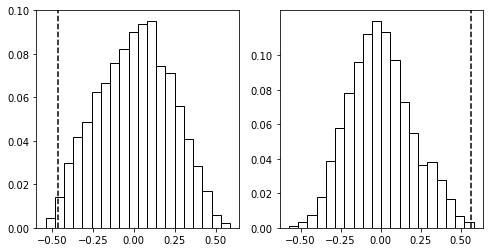

In [5]:
# Perform spin random permutation test on relationship between range/sill and principal gradient

from netneurotools import stats as statsNNT
import nibabel as nib
from scipy import stats




fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)


verts=np.loadtxt('surfL.txt')[SurfaceMask[:5000]==1,:]
vertsR=np.loadtxt('surfR.txt')[SurfaceMask[5000:]==1,:]
num_rotations=5000 # Generate random spins on the sphere.


def divide_yticks(yticks):
    return [tick/num_rotations for tick in yticks]

#spins=statsNNT.gen_spinsamples(verts,np.zeros(verts.shape[0]),n_rotate=num_rotations)

spins=statsNNT.gen_spinsamples(np.vstack((verts,vertsR)),np.hstack((np.zeros(verts.shape[0]),np.ones(vertsR.shape[0]))),n_rotate=num_rotations, seed=23)

ModelCof_evVwBoth=np.vstack((ModelCof_evVw_l,ModelCof_evVw_r))
GradientsBoth=np.vstack((gml.gradients_,gmr.gradients_))

ShuffCor=np.zeros(num_rotations)
g=0
r_s=0
for i in range(num_rotations):
    ShuffCor[i]=stats.pearsonr(ModelCof_evVwBoth[spins[:,i],1,r_s],GradientsBoth[:,g])[0]
    
    #print(stats.spearmanr(ModelCof_evVw_l[spins[:,i],2,0],gml.gradients_[:,2])[0])
    
TrueCorr=stats.pearsonr(ModelCof_evVwBoth[:,1,r_s],GradientsBoth[:,g])[0]
print('Range')
print(np.mean(TrueCorr>ShuffCor))


ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(ShuffCor, bins=20, density=False, rwidth=1, edgecolor="black", facecolor='white')
ax1.axvline(TrueCorr, ls="--", color="k")

yticks = ax1.get_yticks()
yticks_divided = divide_yticks(yticks)
ax1.set_yticks(yticks)
ax1.set_yticklabels(["{:.2f}".format(tick) for tick in yticks_divided])

ShuffCor=np.zeros(num_rotations)
g=0
r_s=1
for i in range(num_rotations):
    ShuffCor[i]=stats.pearsonr(ModelCof_evVwBoth[spins[:,i],1,r_s],GradientsBoth[:,g])[0]
    
TrueCorr=stats.pearsonr(ModelCof_evVwBoth[:,1,r_s],GradientsBoth[:,g])[0]
print('Sill')
print(np.mean(TrueCorr>ShuffCor))
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(ShuffCor, bins=20, density=False, rwidth=1, edgecolor="black", facecolor='white')
ax2.axvline(TrueCorr, ls="--", color="k")

yticks = ax1.get_yticks()
yticks_divided = divide_yticks(yticks)
ax2.set_yticks(yticks)
ax2.set_yticklabels(["{:.2f}".format(tick) for tick in yticks_divided])


plt.savefig('./imagesAvG/GradientRangeSillCorrPerm.png')


In [536]:
print(1-np.mean(TrueCorr>ShuffCor))

0.0013999999999999568


Range
0.9856
Sill
0.0216


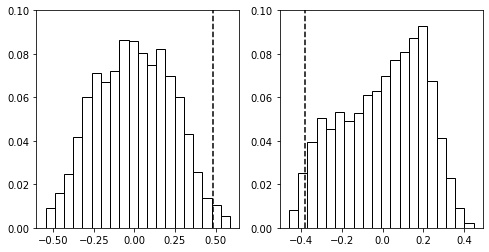

In [537]:
# Perform spin random permutation test on relationship between range/sill and estimated intracortical myelin

from netneurotools import stats as statsNNT # Need to pip install
import nibabel as nib
from scipy import stats




fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)


verts=np.loadtxt('surfL.txt')[SurfaceMask[:5000]==1,:]
vertsR=np.loadtxt('surfR.txt')[SurfaceMask[5000:]==1,:]
num_rotations=5000 # Generate random spins on the sphere.


def divide_yticks(yticks):
    return [tick/num_rotations for tick in yticks]



spins=statsNNT.gen_spinsamples(np.vstack((verts,vertsR)),np.hstack((np.zeros(verts.shape[0]),np.ones(vertsR.shape[0]))),n_rotate=num_rotations, seed=23)

ModelCof_evVwBoth=np.vstack((ModelCof_evVw_l,ModelCof_evVw_r))

Myelin=np.loadtxt('Myelin10k.txt')
tempData=Myelin[:5000]
MyelinReduced=tempData[SurfaceMask[:5000]==1]
tempData=Myelin[5000:]
MyelinReducedR=tempData[SurfaceMask[5000:]==1]


MyelinBoth=np.hstack((MyelinReduced,MyelinReducedR))

ShuffCor=np.zeros(num_rotations)
g=0
r_s=0
for i in range(num_rotations):
    ShuffCor[i]=stats.pearsonr(ModelCof_evVwBoth[spins[:,i],1,r_s],MyelinBoth)[0]
    
    
TrueCorr=stats.pearsonr(ModelCof_evVwBoth[:,1,r_s],MyelinBoth)[0]
print('Range')
print(np.mean(TrueCorr>ShuffCor))



# Create subplots and plot histograms
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(ShuffCor, bins=20, density=False, rwidth=1, edgecolor="black", facecolor='white')
ax1.axvline(TrueCorr, ls="--", color="k")

yticks = ax1.get_yticks()
yticks_divided = divide_yticks(yticks)
ax1.set_yticks(yticks)
ax1.set_yticklabels(["{:.2f}".format(tick) for tick in yticks_divided])



ShuffCor=np.zeros(num_rotations)
g=0
r_s=1
for i in range(num_rotations):
    ShuffCor[i]=stats.pearsonr(ModelCof_evVwBoth[spins[:,i],1,r_s],MyelinBoth)[0]
    
TrueCorr=stats.pearsonr(ModelCof_evVwBoth[:,1,r_s],MyelinBoth)[0]
print('Sill')
print(np.mean(TrueCorr>ShuffCor))
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(ShuffCor, bins=20, density=False, rwidth=1, edgecolor="black", facecolor='white')
ax2.axvline(TrueCorr, ls="--", color="k")

yticks = ax1.get_yticks()
yticks_divided = divide_yticks(yticks)
ax2.set_yticks(yticks)
ax2.set_yticklabels(["{:.2f}".format(tick) for tick in yticks_divided])




plt.savefig('./imagesAvG/MyelinRangeSillCorrPerm.png')



In [ ]:
print(1-np.mean(TrueCorr>ShuffCor))



In [ ]:
# Calculate ICAs and plot with range/sill (Not in paper)
ICA=np.loadtxt('ICA_15RSN10k.txt').T
tempData=ICA[:5000,:]
ICAReduced=tempData[SurfaceMask[:5000]==1,:]
tempData=ICA[5000:,:]
ICAReducedR=tempData[SurfaceMask[5000:]==1,:]



import matplotlib

matplotlib.rc_file_defaults()
#print(np.corrcoef(ModelCof_IndWBev_l[:,1,0],ModelCof_IndWBev_l_2[:,1,0]))

for ic in range(15):
    fig, axs = plt.subplots(1,2,figsize=(8,4))
    fig.patch.set_alpha(0)
    #print(stats.spearmanr(ModelCof_IndWBev_l[:,1,0],ModelCof_IndWBev_l_2[:,1,0]))

    axs[0].scatter(ModelCof_evVw_l[:,1,0],ModelCof_evVw_l[:,1,1],c=ICAReduced[:,ic],cmap='bwr',s=5,vmin=-0.2,vmax=0.2)
    axs[0].grid(False)

    im=axs[1].scatter(ModelCof_evVw_r[:,1,0],ModelCof_evVw_r[:,1,1],c=ICAReducedR[:,ic],cmap='bwr',s=5,vmin=-0.2,vmax=0.2)
    axs[1].grid(False)

    #fig.colorbar(im,ax=axs[1])
    plt.savefig('./imagesAvG/ICASillRange'+ str(ic) +'.png')
    plt.show()



In [ ]:
# Cluster vertexwise variograms and relate to Yeo networks 
import matplotlib 


import seaborn as sns; sns.set_theme(color_codes=True)

import matplotlib.cm as cm
from matplotlib import colors
import pandas as pd
import seaborn as sns

fig = plt.figure(figsize=(8,8))

YeoNames=['NONE',
'7Networks_3',
'7Networks_6',
'7Networks_7',
'7Networks_1',
'7Networks_5',
'7Networks_2',
'7Networks_4'];

YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')
angle=0
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]
RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7,YeoIndices=np.unique(RSNL_masked,return_inverse=True)
YeoColorList=np.zeros([RSNL_masked.shape[0],3])

for i in range(RSNL_masked.shape[0]):
    tempBool=YeoColors[:,1]==YeoNames[YeoIndices[i]]
    temp_col=np.asarray([YeoColors[tempBool,2],YeoColors[tempBool,3],YeoColors[tempBool,4]], dtype=int).ravel()
    YeoColorList[i]=temp_col

X = evVw_l
g = sns.clustermap(X[YeoIndices>0,:], row_colors=YeoColorList[YeoIndices>0]/255,metric="euclidean",method="ward",dendrogram_ratio=(.5, .1),colors_ratio=(0.07,0.03),col_cluster=False,cbar_pos=None,cmap="gray")
g.savefig('./imagesAvG/Dendogram_l.png')

from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(X[YeoIndices>0,:], metric="euclidean",method="ward")

from scipy.cluster.hierarchy import fcluster
fl_l = fcluster(Z,2,criterion='maxclust')

RSNR=RSN[:,5000:]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]
yeo7,YeoIndices=np.unique(RSNR_masked,return_inverse=True)
YeoColorList=np.zeros([RSNR_masked.shape[0],3])


for i in range(RSNR_masked.shape[0]):
    tempBool=YeoColors[:,1]==YeoNames[YeoIndices[i]]
    temp_col=np.asarray([YeoColors[tempBool,2],YeoColors[tempBool,3],YeoColors[tempBool,4]], dtype=int).ravel()
    
    YeoColorList[i]=temp_col


X = evVw_r

g = sns.clustermap(X[YeoIndices>0,:], row_colors=YeoColorList[YeoIndices>0]/255,metric="euclidean",method="ward",dendrogram_ratio=(.5, .1),colors_ratio=(0.07,0.03),col_cluster=False,cbar_pos=None,cmap="gray")

g.savefig('./imagesAvG/Dendogram_r.png')

Z = linkage(X[YeoIndices>0,:], metric="euclidean",method="ward")
fl_r = fcluster(Z,2,criterion='maxclust')*-1


RSNL=RSN[:,:5000]
RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7,YeoIndices=np.unique(RSNL_masked,return_inverse=True)
YeoColorList=np.zeros([RSNL_masked.shape[0],3])

matplotlib.rc_file_defaults()
cmap='bwr'
fig, axs = plt.subplots(1,2,figsize=(8,4))
fig.patch.set_alpha(0)

axs[0].scatter(ModelCof_evVw_l[YeoIndices>0,1,0],ModelCof_evVw_l[YeoIndices>0,1,1],c=fl_l,cmap=cmap,s=5)
axs[0].grid(False)
axs[0].set_ylim(bottom=0.25, top=0.5)

RSNR=RSN[:,5000:]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]
yeo7,YeoIndices=np.unique(RSNR_masked,return_inverse=True)
YeoColorList=np.zeros([RSNR_masked.shape[0],3])

cmap='bwr'

axs[1].scatter(ModelCof_evVw_r[YeoIndices>0,1,0],ModelCof_evVw_r[YeoIndices>0,1,1],c=fl_r,cmap=cmap,s=5)
axs[1].grid(False)
axs[1].set_ylim(bottom=0.25, top=0.5)
plt.savefig('./imagesAvG/ClusterRangeSill.png')



In [ ]:
%matplotlib inline

# Assess out of sample/within participant variogram similarity within and between clusters from step above
import glob
import h5py
import numpy as np

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import helpers

HCPFilenamesList = glob.glob('./IndSubHCP/*.mat')
HCPFilenamesList.sort()
SurfaceMask=np.loadtxt('surfBilateralMask.txt')

numFiles=len(HCPFilenamesList)
numV_l=np.count_nonzero(SurfaceMask[:5000])
numV_l=np.count_nonzero(SurfaceMask[5000:])

num_bins=20
dist_mat_file = "SurfL10kConte.txt"
dist_mat_file_r = "SurfR10kConte.txt"
dist_file=np.loadtxt(dist_mat_file)
dist_file_r=np.loadtxt(dist_mat_file_r)
dist_file_masked=dist_file[np.ix_(SurfaceMask[:5000]==1,SurfaceMask[:5000]==1)]
dist_file_masked_r=dist_file_r[np.ix_(SurfaceMask[5000:]==1,SurfaceMask[5000:]==1)]

verts=dist_file_masked.shape[0]
verts_r=dist_file_masked_r.shape[0]

ind_fc_vw_ev_l=np.zeros([numFiles,verts,num_bins])
ind_fc_vw_h_l=np.zeros([numFiles,verts,num_bins])

ind_fc_vw_ev_r=np.zeros([numFiles,verts_r,num_bins])
ind_fc_vw_h_r=np.zeros([numFiles,verts_r,num_bins])

ind_fc2_vw_ev_l=np.zeros([numFiles,verts,num_bins])
ind_fc2_vw_h_l=np.zeros([numFiles,verts,num_bins])
ind_fc2_vw_ev_r=np.zeros([numFiles,verts_r,num_bins])
ind_fc2_vw_h_r=np.zeros([numFiles,verts_r,num_bins])


for i,dataName in enumerate(HCPFilenamesList):



    print(dataName)
    f = h5py.File(dataName)
    arrays = {}
    for k, v in f.items():
        arrays[k] = np.array(v)

    IndData1=arrays['rfMRI_REST1_LR']
    
    tempData=IndData1[:5000,:]
    tempDataReduced=tempData[SurfaceMask[:5000]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    ind_fc_vw_h_l[i,:,:],ind_fc_vw_ev_l[i,:,:]=helpers.emp_variogram_vwise_conn(tempFC,dist_file_masked,num_bins,[0,150])

    
    
    
    tempData=IndData1[5000:,:]
    tempDataReduced=tempData[SurfaceMask[5000:]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    ind_fc_vw_h_r[i,:],ind_fc_vw_ev_r[i,:]=helpers.emp_variogram_vwise_conn(tempFC,dist_file_masked_r,num_bins,[0,150])
    
    
    IndData1=arrays['rfMRI_REST1_RL']
    
    tempData=IndData1[:5000,:]
    tempDataReduced=tempData[SurfaceMask[:5000]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    ind_fc2_vw_h_l[i,:,:],ind_fc2_vw_ev_l[i,:,:]=helpers.emp_variogram_vwise_conn(tempFC,dist_file_masked,num_bins,[0,150])

    
    
    
    tempData=IndData1[5000:,:]
    tempDataReduced=tempData[SurfaceMask[5000:]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    ind_fc2_vw_h_r[i,:],ind_fc2_vw_ev_r[i,:]=helpers.emp_variogram_vwise_conn(tempFC,dist_file_masked_r,num_bins,[0,150])
    


In [ ]:
# Show variograms for each cluster
from scipy.ndimage.filters import gaussian_filter1d
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

fig, axs = plt.subplots(1,2,figsize=(8,4))

fig.patch.set_alpha(0)

RSNR_masked=RSNR[RSNAtlas,SurfaceMask[:5000]==1]
yeo7,YeoIndices=np.unique(RSNR_masked,return_inverse=True)


power=2

X=ind_fc_vw_h_l[0,0,:]

smoothing=0.9
mu=ind_fc_vw_ev_l[:,tempData1==2,:].mean(axis=0).mean(axis=0)

sigma = ind_fc_vw_ev_l[:,tempData1==2,:].std(axis=0).mean(axis=0)*1.96/np.power(51,0.5)


mu_s = gaussian_filter1d(mu, sigma=smoothing)
sigma_s = gaussian_filter1d(sigma, sigma=smoothing)

axs[0].fill_between(X, mu_s-sigma_s, mu_s+sigma_s, facecolor='red',
                edgecolor='none', alpha=0.2)
axs[0].plot(X, mu, 'o',color='red')

mu=ind_fc_vw_ev_l[:,tempData1==1,:].mean(axis=0).mean(axis=0)

sigma = ind_fc_vw_ev_l[:,tempData1==1,:].std(axis=0).mean(axis=0)*1.96/np.power(51,0.5)


mu_s = gaussian_filter1d(mu, sigma=smoothing)
sigma_s = gaussian_filter1d(sigma, sigma=smoothing)

axs[0].fill_between(X, mu_s-sigma_s, mu_s+sigma_s, facecolor='blue',
                edgecolor='none', alpha=0.2)
axs[0].plot(X, mu, 'o',color='blue')



plt.savefig('./imagesAvG/ClusterTemp.png',dpi=300) 



In [ ]:
# Calculate myelin per cluster

AllMye=np.loadtxt('AllMyelin10k.txt').T
AllMyeLeft=AllMye[:5000,:]
#print(AllMyeLeft.shape)
AllMyeReduced=AllMyeLeft[SurfaceMask[:5000]==1,:]
RSNL=RSN[:,:5000]
RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7,YeoIndices=np.unique(RSNL_masked,return_inverse=True)
AllMyeReducedNoWall=AllMyeReduced[YeoIndices>0,:]

fig = plt.figure(figsize=(4,4))

sns.set_style("white")

#my_pal={[1,0,0],"b"}
my_pal={'r',"b"}
data=np.vstack((np.mean(AllMyeReducedNoWall[fl_l==2],axis=0), np.mean(AllMyeReducedNoWall[fl_l==1],axis=0))).T

ax = sns.violinplot(data=data,palette=my_pal,inner="box",orient='v',saturation=1,bw=1,cut=2,width=0.95)
ax.set_xticklabels(['1','2'])
ax.set(xlabel='Cluster', ylabel='Average intracortical myelin')
sns.despine(offset=0, trim=False);

fig.savefig('./imagesAvG/MyelinByCluster.png')


In [ ]:
%matplotlib inline

# Calculate average variogram for each Yeo network for human and macaque monkey
import glob
import h5py
import numpy as np
#from brainspace.gradient import GradientMaps
#from brainspace.gradient import alignment
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import helpers
import scipy.io
import seaborn as sns; sns.set_theme(color_codes=True)

num_bins=20


f = scipy.io.loadmat('./data_PRIME/geo_distance/Schaefer400_L.mat')

GeoDistL=f['geoParcel_L']

f = scipy.io.loadmat('./data_PRIME/geo_distance/Schaefer400_R.mat')

GeoDistR=f['geoParcel_R']

f=scipy.io.loadmat('./data_PRIME/site-newcastle/FC_GroupAvg_Schaefer400.mat')


FC=f['FC']


FC_left=FC[np.ix_(np.arange(200),np.arange(200))]


FC_right=FC[np.ix_(np.arange(200)+200,np.arange(200)+200)] #check
h_l,ev_l=helpers.emp_variogram_conn(FC_left,GeoDistL,num_bins,[0,80])
h_r,ev_r=helpers.emp_variogram_conn(FC_right,GeoDistR,num_bins,[0,80])

hVw_l,evVw_l=helpers.emp_variogram_vwise_conn(FC_left,GeoDistL,num_bins,[0,80]) #vary last number for maximum range 
hVw_r,evVw_r=helpers.emp_variogram_vwise_conn(FC_right,GeoDistR,num_bins,[0,80]) #vary last number for maximum range 




Schaeffer400LUT=np.loadtxt('Schaeffer400Colors.txt')
Schaeffer400Labels=np.loadtxt('Schaeffer400Yeo7Labels.txt',dtype=str)

indexes = np.unique(Schaeffer400Labels, return_index=True)[1]
[Schaeffer400Labels[index] for index in sorted(indexes)]


indexes = np.unique(Schaeffer400Labels, return_index=True)[1]
Yeo7_Monkey_ev_l=np.zeros([indexes.shape[0],num_bins])
Yeo7_Monkey_h_l=np.zeros([indexes.shape[0],num_bins])
Yeo7_Monkey_ev_r=np.zeros([indexes.shape[0],num_bins])
Yeo7_Monkey_h_r=np.zeros([indexes.shape[0],num_bins])

for i,index in enumerate(sorted(indexes)):
    Yeo7_Monkey_ev_l[i,:]=evVw_l[Schaeffer400Labels[:200]==Schaeffer400Labels[index],:].mean(axis=0)
    Yeo7_Monkey_h_l[i,:]=hVw_l[Schaeffer400Labels[:200]==Schaeffer400Labels[index],:].mean(axis=0)
    Yeo7_Monkey_ev_r[i,:]=evVw_r[Schaeffer400Labels[200:]==Schaeffer400Labels[index],:].mean(axis=0)
    Yeo7_Monkey_h_r[i,:]=hVw_r[Schaeffer400Labels[200:]==Schaeffer400Labels[index],:].mean(axis=0)

    



from matplotlib import colors
hVw_l,evVw_l=helpers.emp_variogram_vwise_conn(FC_l,dist_file_masked,num_bins,[0,150]) #vary last number for maximum range 
hVw_r,evVw_r=helpers.emp_variogram_vwise_conn(FC_r,dist_file_masked_r,num_bins,[0,150]) #vary last number for maximum range 

indexes = np.unique(Schaeffer400Labels, return_index=True)[1]
LUT=[Schaeffer400LUT[index] for index in sorted(indexes)]

NumNetworks=7


plt.style.use('default')
fig = plt.figure(figsize=(9*2,4))
fig.patch.set_alpha(0)
count=0
for i in range(NumNetworks):
    ax = fig.add_subplot(1,NumNetworks, count+1)
    rgbtohex=colors.to_hex(LUT[i])
    plt.plot(Yeo7_Monkey_h_l[i,1:18],Yeo7_Monkey_ev_l[i,1:18],c=rgbtohex,linestyle='dashed')
    ax.set_ylim(bottom=0, top=0.55)
    count=count+1
    
YeoNames=['NONE',
'7Networks_3',
'7Networks_6',
'7Networks_7',
'7Networks_1',
'7Networks_5',
'7Networks_2',
'7Networks_4'];

 

side='left'
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)
vw_yeo=np.zeros([len(yeo7),num_bins])
vw_yeo_sd=np.zeros([len(yeo7),num_bins])
for i,YeoID in enumerate(yeo7):
    vw_yeo[i,:]=evVw_l[RSNL_masked==YeoID].mean(axis=0)
    vw_yeo_sd[i,:]=evVw_l[RSNL_masked==YeoID].std(axis=0)
    


YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')


count=0
axs = fig.get_axes()
for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            x=hVw_l[0,:]
            y=vw_yeo[j,:]
            y_sd=vw_yeo_sd[j,:]
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            axs[count].grid(False)
            rgbtohex=colors.to_hex(temp_col/255)
            ax2 = axs[count].twinx() 
            ax2.fill_between(x, y-y_sd, y+y_sd, facecolor=rgbtohex,edgecolor='none', alpha=0.2)
            ax2.plot(x, y, color=rgbtohex, lw=1)
            ax2.grid(False)
            
            ax2.set_ylim(bottom=0, top=0.45)


            count=count+1


fig.tight_layout(pad=3.0)


plt.savefig('./imagesAvG/VWByYeoMonkeyHumanLeft.png')


In [ ]:
# Calculate average range and sill for each Yeo network
from matplotlib import colors


YeoNames=['NONE',
'7Networks_3',
'7Networks_6',
'7Networks_7',
'7Networks_1',
'7Networks_5',
'7Networks_2',
'7Networks_4'];

 

side='left'
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])
for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,0].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,0].std()/np.power(np.sum(RSNL_masked==YeoID),0.5)
    


YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')

fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
count=0

ax = fig.add_subplot(1,2, 1)
for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:

            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1

ax.set_xticklabels([])
ax.set_xticks([]) 
ax = fig.add_subplot(1,2, 2)


RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNR=RSN[:,5000:]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]
yeo7=np.unique(RSNR_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])

for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,0].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,0].std()/np.power(np.sum(RSNR_masked==YeoID),0.5)
    



for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            #x=hVw_l[0,:]
            #print(vw_yeo_Range[j])
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1
            
ax.set_xticklabels([])
ax.set_xticks([])
  
plt.savefig('./imagesAvG/VWRangeByYeo.png')



side='left'
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])
for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,1].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,1].std()/np.power(np.sum(RSNL_masked==YeoID),0.5)
    


YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')

fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
count=0

ax = fig.add_subplot(1,2, 1)
for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            #x=hVw_l[0,:]
            #print(vw_yeo_Range[j])
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1

ax.set_xticklabels([])
ax.set_xticks([]) 
ax.set_ylim(0.25,0.5)
ax = fig.add_subplot(1,2, 2)


RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNR=RSN[:,5000:]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]
yeo7=np.unique(RSNR_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])

for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,1].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,1].std()/np.power(np.sum(RSNR_masked==YeoID),0.5)
    



for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:

            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1
            
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_ylim(0.25,0.5)
  
plt.savefig('./imagesAvG/VVSillByYeo.png')




In [ ]:
# Spin permutation test for Yeo networks. 

from matplotlib import colors

RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')

RSNL=RSN[:,:5000]
num_rotations=5000
RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)

side='left'

RSNR=RSN[:,5000:]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]

RSN_maskedBoth=np.hstack((RSNL_masked,RSNR_masked))
yeo7=np.unique(RSNL_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Sill=np.zeros([len(yeo7)])
vw_yeo_RangeR=np.zeros([len(yeo7)])
vw_yeo_SillR=np.zeros([len(yeo7)])

ModelCof_evVwBoth=np.vstack((ModelCof_evVw_l,ModelCof_evVw_r))

for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVwBoth[RSN_maskedBoth==YeoID,1,0].mean()
    vw_yeo_Sill[i]=ModelCof_evVwBoth[RSN_maskedBoth==YeoID,1,1].mean()
    
Spin_vw_yeo_Range=np.zeros([num_rotations,len(yeo7)])
Spin_vw_yeo_Sill=np.zeros([num_rotations,len(yeo7)])

verts=np.loadtxt('surfL.txt')[SurfaceMask[:5000]==1,:]
vertsR=np.loadtxt('surfR.txt')[SurfaceMask[5000:]==1,:]
spins=statsNNT.gen_spinsamples(np.vstack((verts,vertsR)),np.hstack((np.zeros(verts.shape[0]),np.ones(vertsR.shape[0]))),n_rotate=num_rotations, seed=23)


for n in range(num_rotations):

    for i,YeoID in enumerate(yeo7):

        Spin_vw_yeo_Range[n,i]=ModelCof_evVwBoth[RSN_maskedBoth[spins[:,n]]==YeoID,1,0].mean()
        Spin_vw_yeo_Sill[n,i]=ModelCof_evVwBoth[RSN_maskedBoth[spins[:,n]]==YeoID,1,1].mean()
        
        

YeoNames=['NONE',
'7Networks_3',
'7Networks_6',
'7Networks_7',
'7Networks_1',
'7Networks_5',
'7Networks_2',
'7Networks_4'];


YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')
TrueGrTShuff=np.zeros([7,2])

fig = plt.figure(figsize=(28,4))
fig.patch.set_alpha(0)
count=0

for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            count=count+1
            ax = fig.add_subplot(1,7, count)

            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            
            aa=Spin_vw_yeo_Range[:,j]
            bb=vw_yeo_Range[j]
            
            ax.hist(aa,bins=20,color=rgbtohex,density=False,rwidth=1,edgecolor="black")
            ax.axvline(bb, ls="--", color="k")
            TrueGrTShuff[count-1,0]=np.mean(vw_yeo_Range[j]>Spin_vw_yeo_Range[:,j])
            yticks = ax.get_yticks()
            yticks_divided = divide_yticks(yticks)
            ax.set_yticks(yticks)
            ax.set_yticklabels(["{:.2f}".format(tick) for tick in yticks_divided])

            yticks = ax.get_yticks()
            yticks_divided = divide_yticks(yticks)
            ax.set_yticks(yticks)
            ax.set_yticklabels(["{:.2f}".format(tick) for tick in yticks_divided])


plt.savefig('./imagesAvG/YeoPermutationRange.png')
plt.show()
fig = plt.figure(figsize=(28,4))
fig.patch.set_alpha(0)
count=0

for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            count=count+1
            ax = fig.add_subplot(1,7, count)

            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            
            aa=Spin_vw_yeo_Sill[:,j]
            bb=vw_yeo_Sill[j]
            
            ax.hist(aa,bins=20,color=rgbtohex,density=False,rwidth=1,edgecolor="black")
            ax.axvline(bb, ls="--", color="k")
            TrueGrTShuff[count-1,1]=np.mean(vw_yeo_Sill[j]>Spin_vw_yeo_Sill[:,j])
            yticks = ax.get_yticks()
            yticks_divided = divide_yticks(yticks)
            ax.set_yticks(yticks)
            ax.set_yticklabels(["{:.2f}".format(tick) for tick in yticks_divided])

            yticks = ax.get_yticks()
            yticks_divided = divide_yticks(yticks)
            ax.set_yticks(yticks)
            ax.set_yticklabels(["{:.2f}".format(tick) for tick in yticks_divided])

            

plt.savefig('./imagesAvG/YeoPermutationSill.png')
plt.show()


# 2-tailed test
pvals=np.min([TrueGrTShuff,1-TrueGrTShuff],axis=0)

pvals_rs=pvals.reshape([14])

import statsmodels.stats.multitest as smm
print(smm.multipletests(pvals_rs, alpha=0.05, method='fdr_bh'))

print(pvals)
print(pvals_rs)



In [211]:
# Calculate differences in range and sill between Yeo networks
SpinYeoConfSill=np.zeros([5000,7,7])
SpinYeoConfRange=np.zeros([5000,7,7])
YeoNums=[3,6,7,1,5,2,4]

for i in range(7):
    for j in range(7):
        for k in range(5000):
            SpinYeoConfSill[k,YeoNums[i]-1,YeoNums[j]-1]=(Spin_vw_yeo_Sill[k,i+1]-Spin_vw_yeo_Sill[k,j+1])
            SpinYeoConfRange[k,YeoNums[i]-1,YeoNums[j]-1]=(Spin_vw_yeo_Range[k,i+1]-Spin_vw_yeo_Range[k,j+1])

            

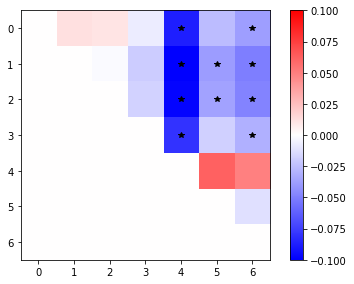

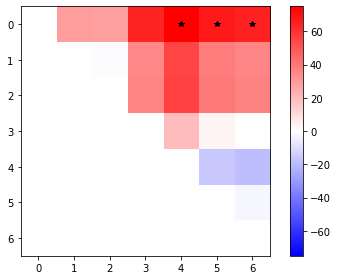

In [535]:
# Plot the "confusion" matrix between the networks

plt.imshow(np.triu(YeoSillConfMeanDiff,1),vmin=-0.1,vmax=0.1,cmap='bwr')

pvals_rs=1-YeoSillConfPVal[np.triu_indices(7,1)]

pvals_origShape=np.zeros([7,7])

pvals_origShape[np.triu_indices(7,1)]=smm.multipletests(pvals_rs, alpha=0.1, method='fdr_bh')[0]


LogicalSill=np.triu(np.logical_or(YeoSillConfPVal<0.05, YeoSillConfPVal>0.95),1)
for i in range(7):
    for j in range(7):
        if i>j and pvals_origShape[j,i]==1:
            plt.plot(i,j,'*',c='k')

plt.tight_layout()


plt.colorbar()
plt.savefig('./imagesAvG/SillYeoComparisons.png')
plt.show()

LogicalRange=np.triu(np.logical_or(YeoRangeConfPVal>0.05, YeoRangeConfPVal>0.95),1)
plt.imshow(np.triu(YeoRangeConfMeanDiff,1),vmin=-75,vmax=75,cmap='bwr')

pvals_rs=1-YeoRangeConfPVal[np.triu_indices(7,1)]
#pvals_rs=1-YeoSillConfPVal[np.triu_indices(7,1)]          
#import statsmodels.stats.multitest as smm
pvals_origShape=np.zeros([7,7])

pvals_origShape[np.triu_indices(7,1)]=smm.multipletests(pvals_rs, alpha=0.1, method='fdr_bh')[0]



for i in range(7):
    for j in range(7):
        if i>j and pvals_origShape[j,i]==1:
            plt.plot(i,j,'*',c='k')
            
plt.tight_layout()
plt.colorbar()
plt.savefig('./imagesAvG/RangeYeoComparisons.png')



In [431]:
# Calculate fdr correction 

pvals_origShape[np.triu_indices(7,1)]=smm.multipletests(pvals_rs, alpha=0.1, method='fdr_bh')[0]



array([[0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
# Spin Null for Yeo averages
from matplotlib import colors


YeoNames=['NONE',
'7Networks_3',
'7Networks_6',
'7Networks_7',
'7Networks_1',
'7Networks_5',
'7Networks_2',
'7Networks_4'];

 

side='left'
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])
for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,0].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,0].std()/np.power(np.sum(RSNL_masked==YeoID),0.5)
    


YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')

fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
count=0

ax = fig.add_subplot(1,2, 1)
for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            #x=hVw_l[0,:]
            #print(vw_yeo_Range[j])
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1

ax.set_xticklabels([])
ax.set_xticks([]) 
ax = fig.add_subplot(1,2, 2)


RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNR=RSN[:,5000:]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]
yeo7=np.unique(RSNR_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])

for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,0].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,0].std()/np.power(np.sum(RSNR_masked==YeoID),0.5)
    



for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            #x=hVw_l[0,:]
            #print(vw_yeo_Range[j])
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1
            
ax.set_xticklabels([])
ax.set_xticks([])
  
plt.savefig('./imagesAvG/VWRangeByYeo.png')



side='left'
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])
for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,1].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,1].std()/np.power(np.sum(RSNL_masked==YeoID),0.5)
    


YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')

fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
count=0

ax = fig.add_subplot(1,2, 1)
for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            #x=hVw_l[0,:]
            #print(vw_yeo_Range[j])
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1

ax.set_xticklabels([])
ax.set_xticks([]) 
ax.set_ylim(0.25,0.5)
ax = fig.add_subplot(1,2, 2)


RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNR=RSN[:,5000:]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]
yeo7=np.unique(RSNR_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])

for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,1].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,1].std()/np.power(np.sum(RSNR_masked==YeoID),0.5)
    



for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            #x=hVw_l[0,:]
            #print(vw_yeo_Range[j])
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1
            
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_ylim(0.25,0.5)
  
plt.savefig('./imagesAvG/VVSillByYeo.png')




In [ ]:
# Plot cross scan 

yeo7,YeoIndices=np.unique(RSNL_masked,return_inverse=True)
vw_clust_ind1=np.zeros([ind_fc_vw_ev_l.shape[0],2,ind_fc_vw_ev_l.shape[2]])
vw_clust_ind2=np.zeros([ind_fc2_vw_ev_l.shape[0],2,ind_fc2_vw_ev_l.shape[2]])
for i in range(51):
    vw_clust_ind1[i,0,:]=ind_fc_vw_ev_l[i,YeoIndices>0,:][np.where(fl_l==1)].mean(axis=0)
    vw_clust_ind2[i,0,:]=ind_fc2_vw_ev_l[i,YeoIndices>0,:][np.where(fl_l==1)].mean(axis=0)
    vw_clust_ind1[i,1,:]=ind_fc_vw_ev_l[i,YeoIndices>0,:][np.where(fl_l==2)].mean(axis=0)
    vw_clust_ind2[i,1,:]=ind_fc2_vw_ev_l[i,YeoIndices>0,:][np.where(fl_l==2)].mean(axis=0)

    
Clust_cross_sample_corrs=np.zeros([vw_yeo_ind1.shape[0],2,2])
for i in range(vw_clust_ind1.shape[0]):
    for j in range(vw_clust_ind1.shape[1]):
        for k in range(vw_clust_ind2.shape[1]):
             
            Clust_cross_sample_corrs[i,j,k]=np.arctanh(np.corrcoef(vw_clust_ind1[i,j,:],vw_clust_ind2[i,k,:])[0][1])

print(Clust_cross_sample_corrs.shape)
mean_clust=Clust_cross_sample_corrs.mean(axis=0)
std_clust=Clust_cross_sample_corrs.std(axis=0)

fig = plt.figure(figsize=(8,4))

for i in range(2):
    ax = fig.add_subplot(1,2, i+1)
    plt.bar(np.arange(2),mean_clust[i,:],bottom=0,yerr=std_clust[i,:]/np.power(51,0.5),color=['red','blue'])

    if i ==0:
        plt.bar(i,mean_clust[i,0],bottom=0,hatch="//",color='red')
    else:
        plt.bar(i,mean_clust[i,1],bottom=0,hatch="//",color='blue')

    plt.ylim(1,4)

fig.savefig('./imagesAvG/CrossScanSimilarityVariogeramsByClust_l.png')


yeo7,YeoIndices=np.unique(RSNR_masked,return_inverse=True)
vw_clust_ind1=np.zeros([ind_fc_vw_ev_r.shape[0],2,ind_fc_vw_ev_r.shape[2]])
vw_clust_ind2=np.zeros([ind_fc2_vw_ev_r.shape[0],2,ind_fc2_vw_ev_r.shape[2]])
for i in range(51):
    vw_clust_ind1[i,0,:]=ind_fc_vw_ev_r[i,YeoIndices>0,:][np.where(fl_l==1)].mean(axis=0)
    vw_clust_ind2[i,0,:]=ind_fc2_vw_ev_r[i,YeoIndices>0,:][np.where(fl_l==1)].mean(axis=0)
    vw_clust_ind1[i,1,:]=ind_fc_vw_ev_r[i,YeoIndices>0,:][np.where(fl_l==2)].mean(axis=0)
    vw_clust_ind2[i,1,:]=ind_fc2_vw_ev_r[i,YeoIndices>0,:][np.where(fl_l==2)].mean(axis=0)

    
Clust_cross_sample_corrs=np.zeros([vw_yeo_ind1.shape[0],2,2])
for i in range(vw_clust_ind1.shape[0]):
    for j in range(vw_clust_ind1.shape[1]):
        for k in range(vw_clust_ind2.shape[1]):
    
            Clust_cross_sample_corrs[i,j,k]=np.arctanh(np.corrcoef(vw_clust_ind1[i,j,:],vw_clust_ind2[i,k,:])[0][1])

mean_clust=Clust_cross_sample_corrs.mean(axis=0)
std_clust=Clust_cross_sample_corrs.std(axis=0)
fig = plt.figure(figsize=(8,4))

for i in range(2):
    ax = fig.add_subplot(1,2, i+1)
    plt.bar(np.arange(2),mean_clust[i,:],bottom=0,yerr=std_clust[i,:]/np.power(51,0.5),color=['red','blue'])

    if i ==0:
        plt.bar(i,mean_clust[i,0],bottom=0,hatch="//",color='red')
    else:
        plt.bar(i,mean_clust[i,1],bottom=0,hatch="//",color='blue')

    plt.ylim(1,4)

fig.savefig('./imagesAvG/CrossScanSimilarityVariogeramsByClust_r.png')



In [ ]:
# Plot the relationship between sill/range and myelin


import matplotlib 
matplotlib.rc_file_defaults()


Myelin=np.loadtxt('Myelin10k.txt')
tempData=Myelin[:5000]
MyelinReduced=tempData[SurfaceMask[:5000]==1]

cmap='PiYG'
fig, axs = plt.subplots(1,2,figsize=(8,4))
fig.patch.set_alpha(0)
axs[0].scatter(ModelCof_evVw_l[:,1,0],ModelCof_evVw_l[:,1,1],c=MyelinReduced,cmap=cmap,s=5)
axs[0].grid(False)
axs[0].set_ylim(bottom=0.25, top=0.5)


tempData=Myelin[5000:]
MyelinReduced=tempData[SurfaceMask[5000:]==1]
fig.patch.set_alpha(0)
im=axs[1].scatter(ModelCof_evVw_r[:,1,0],ModelCof_evVw_r[:,1,1],c=MyelinReduced,cmap=cmap,s=5)
axs[1].grid(False)
axs[1].set_ylim(bottom=0.25, top=0.5)

plt.savefig('./imagesAvG/MyelinRangeSill.png')



In [ ]:

YeoNames=['NONE',
'7Networks_3',
'7Networks_6',
'7Networks_7',
'7Networks_1',
'7Networks_5',
'7Networks_2',
'7Networks_4'];
 


side='left'
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)
vw_yeo_ind1=np.zeros([numFiles,len(yeo7),num_bins])
vw_yeo_ind2=np.zeros([numFiles,len(yeo7),num_bins])

for i in range(numFiles):
    for j,YeoID in enumerate(yeo7):
        vw_yeo_ind1[i,j,:]=ind_fc_vw_ev_l[i,RSNL_masked==YeoID,:].mean(axis=0)
        vw_yeo_ind2[i,j,:]=ind_fc2_vw_ev_l[i,RSNL_masked==YeoID,:].mean(axis=0)

    
    
RSNR=RSN[:,5000:]


RSNR_masked=RSNL[RSNAtlas,SurfaceMask[5000:]==1]
yeo7=np.unique(RSNR_masked)
vw_yeo_ind1_r=np.zeros([numFiles,len(yeo7),num_bins])
vw_yeo_ind2_r=np.zeros([numFiles,len(yeo7),num_bins])
#ind_vw_yeo_sd=np.zeros([len(yeo7),num_bins])
for i in range(numFiles):
    for j,YeoID in enumerate(yeo7):
        vw_yeo_ind1_r[i,j,:]=ind_fc_vw_ev_r[i,RSNR_masked==YeoID,:].mean(axis=0)
        vw_yeo_ind2_r[i,j,:]=ind_fc2_vw_ev_r[i,RSNR_masked==YeoID,:].mean(axis=0)

    


In [ ]:
# Show variograms for different levels (deciles) of myelin

Myelin=np.loadtxt('Myelin10k.txt')


tempData=Myelin[:5000]
MyelinReduced=tempData[SurfaceMask[:5000]==1]

percent_width=10
fig=plt.figure(figsize=(8*2,8))
ax = fig.add_subplot(1,2, 1)
fig.patch.set_alpha(0)
count=0
ind_ev_meanByMyelin=np.zeros([51,10,20])
for i in range(0, 100, percent_width):
    
    for j in range(51):
        lowP=np.percentile(MyelinReduced, i)
        highP=np.percentile(MyelinReduced, i+percent_width)
        ind_ev_meanByMyelin[j,count,:]=ind_fc_vw_ev_l[j,np.where((MyelinReduced > lowP) & (MyelinReduced <= highP)),:].mean(axis=1)[0]
        
    tempAv=ind_ev_meanByMyelin[:,count,:].mean(axis=0).T
    tempStd=ind_ev_meanByMyelin[:,count,:].std(axis=0).T/np.sqrt(51)

    color=i/100
    cmap = matplotlib.cm.get_cmap('PiYG')
    rgba = cmap(color)
    ax.plot(ind_fc_vw_h_l[0,0,:],tempAv,label=[str(i)],c=rgba)

    ax.fill_between(ind_fc_vw_h_l[0,0,:], tempAv-tempStd, tempAv+tempStd,facecolor=rgba,edgecolor='none', alpha=0.1)
    count=count+1
    


tempData=Myelin[5000:]
MyelinReduced=tempData[SurfaceMask[5000:]==1]

percent_width=10

ax = fig.add_subplot(1,2, 2)

count=0
ind_ev_meanByMyelin=np.zeros([51,10,20])
for i in range(0, 100, percent_width):
    
    for j in range(51):
        lowP=np.percentile(MyelinReduced, i)
        highP=np.percentile(MyelinReduced, i+percent_width)

        ind_ev_meanByMyelin[j,count,:]=ind_fc_vw_ev_r[j,np.where((MyelinReduced > lowP) & (MyelinReduced <= highP)),:].mean(axis=1)[0]
        
    tempAv=ind_ev_meanByMyelin[:,count,:].mean(axis=0)
    tempStd=ind_ev_meanByMyelin[:,count,:].std(axis=0)/np.sqrt(51)
    color=i/100
    cmap = matplotlib.cm.get_cmap('PiYG')
    rgba = cmap(color)


    ax.plot(ind_fc_vw_h_r[0,0,:],tempAv,label=[str(i)],c=rgba)

    ax.fill_between(ind_fc_vw_h_r[0,0,:], tempAv-tempStd, tempAv+tempStd,facecolor=rgba,edgecolor='none', alpha=0.2)
    count=count+1
        
    
    
    

fig.savefig('./imagesAvG/VW_Vg_ByMyelinDeciles.png',transparent=True)



In [ ]:
# Find average vertexwise variograms for different Neurosynth topic maps

import matplotlib 
from adjustText import adjust_text
matplotlib.rc_file_defaults()

Tasks=np.loadtxt('TopicAll50.txt')

SurfaceMask=np.loadtxt('surfBilateralMask.txt')

Topics50TNames=np.loadtxt('TermMaps/TopicOrder.txt',delimiter=',',dtype='str')



SurfaceMask=np.loadtxt('surfBilateralMask.txt')


Topics50TNames=np.loadtxt('TermMaps/TopicOrder.txt',delimiter=',',dtype='str')


taskIndices=[6,7,8,9,10,12,17,18,20,23,25,26,30,31,34,35,36,38,39,41,46,47,48,49]

TopicNamesSimplified=['cognitive','inhibition','motor','numerical','action','conflict','spatial','emotion','empathy','decision','pain','memory','language','semantic','face','imagery','visual','eye movement','motion','attention','auditory','reward','social','working memory']
TasksL=Tasks[taskIndices,:5000]
TasksR=Tasks[taskIndices,5000:]

TasksL_masked=TasksL[:,SurfaceMask[:5000]==1]
TasksR_masked=TasksL[:,SurfaceMask[5000:]==1]


ModelAvByTask=np.zeros([24,2])
ModelAvByTaskR=np.zeros([24,2])


for i in range(24):
    ModelAvByTask[i,0]=ModelCof_evVw_l[np.abs(TasksL_masked[i,:])>10,1,0].mean()
    ModelAvByTask[i,1]=ModelCof_evVw_l[np.abs(TasksL_masked[i,:])>10,1,1].mean()

    ModelAvByTaskR[i,0]=ModelCof_evVw_r[np.abs(TasksR_masked[i,:])>10,1,0].mean()
    ModelAvByTaskR[i,1]=ModelCof_evVw_r[np.abs(TasksR_masked[i,:])>10,1,1].mean()




In [ ]:
# Plot the average sill/range for each topic map on the variogram clusters

from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5)
knn.fit(ModelCof_evVw_l[YeoIndices>0,1,0:2])

nn_fl_l=fl_l[knn.kneighbors(ModelAvByTask, return_distance=False,n_neighbors=20)]
nn_fl_lAv=np.mean(nn_fl_l,axis=1)



X=ModelAvByTask[:,0]
Y=ModelAvByTask[:,1]
fig, axs = plt.subplots(1,2,figsize=(16,8))
fig.patch.set_alpha(0)
axs[0].scatter(X,Y,c=nn_fl_lAv,marker = 'o',cmap='bwr')
#axs[0].scatter(X[nn_fl_lAv==1],Y[nn_fl_lAv==1],c='blue',marker = 'o')
texts = [axs[0].text(X[i], Y[i], TopicNamesSimplified[i],fontname="Arial",fontsize=13) for i in range(len(X))]
#adjust_text(texts,arrowprops=dict(arrowstyle='->', color='red'))
adjust_text(texts,ax=axs[0],arrowprops=dict(arrowstyle='->', color='grey'),expand_text=(2, 2), expand_points=(2, 2))
axs[0].set_ylim(bottom=0.33, top=0.41)
axs[0].set_xlim(left=30, right=90)
#axs[0].set_clim(vmin=1, vmax=2)
axs[0].grid(True)
for im in plt.gca().get_images():
    im.set_clim(1, 2)

plt.savefig('./imagesAvG/TaskRangeSillAltCluster.png',dpi=300) 


fig, axs = plt.subplots(1,2,figsize=(16,8))
fig.patch.set_alpha(0)
axs[0].scatter(X,Y,c='k',marker = 'x',s=100)

texts = [axs[0].text(X[i], Y[i], TopicNamesSimplified[i],fontname="Arial",fontsize=13) for i in range(len(X))]

adjust_text(texts,ax=axs[0],arrowprops=dict(arrowstyle='->', color='grey'),expand_text=(2, 2), expand_points=(2, 2))
X=ModelCof_evVw_l[YeoIndices>0,1,0]
Y=ModelCof_evVw_l[YeoIndices>0,1,1]

axs[0].scatter(X[fl_l==2],Y[fl_l==2],c='red',marker = 'o',alpha=0.05)
axs[0].scatter(X[fl_l==1],Y[fl_l==1],c='blue',marker = 'o',alpha=0.05)

axs[0].set_ylim(bottom=0.32, top=0.41)
axs[0].set_xlim(left=30, right=90)

plt.savefig('./imagesAvG/TaskRangeSillOverlayCluster.png',dpi=300) 